In [1]:
# need to connect to db
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

In [2]:
import sklearn, pickle, time, seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
with open('candidates_TrainValTest25similar.pickle', 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 13007 candidates
Split = 1 : imported 3242 candidates
Split = 2 : imported 8221 candidates
Split = 3 : imported 130424 candidates


In [5]:
# Rebuild text
from sklearn_bridge import recreate_text_representation
# take text + labels from train ds
from sklearn_bridge import candidate_dict_to_df

In [6]:
df_train = candidate_dict_to_df(candidate_dict[0],trim_text=True, window=5, lemmas = True, shortest_dep_path= False)
df_test = candidate_dict_to_df(candidate_dict[2],trim_text=True, window=5, lemmas = True, shortest_dep_path= False)
df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=True, window=5, lemmas = True, shortest_dep_path= False)


## Filter out results, leave only those with similarity > X

In [150]:
# # load document pubmed ids which are more similar than 5e7 from pickle
# with open('/home/antonis/data/biocreative6/pubmed_ids_5e7similarity.pickle', 'rb') as f:
#     ids5 = pickle.load(f)

In [249]:
# load document pubmed ids which are more similar than 5e7 from pickle
with open('/home/antonis/data/biocreative6/pubmed_ids_25similar_scores.pickle', 'rb') as f:
    pubmed_sim_scores = pickle.load(f)

In [250]:
pubmed_sim_scores

{'16845449': 46098962,
 '18424637': 34411400,
 '17030905': 37812595,
 '19549076': 47345090,
 '15663198': 47077165,
 '25680322': 74242097,
 '20652686': 22282218,
 '11135733': 34978114,
 '7523207': 47760755,
 '15719584': 44529414,
 '11414710': 44687642,
 '25063231': 37202672,
 '16918396': 32548802,
 '20099201': 38249626,
 '18048478': 37765064,
 '20384467': 29172653,
 '21439689': 32869839,
 '14978197': 25646993,
 '10215651': 33219110,
 '8790025': 44688133,
 '7906269': 55448722,
 '21550385': 36514157,
 '21968035': 27664538,
 '25887397': 44347839,
 '11321505': 35756670,
 '16684433': 40730227,
 '20835859': 38871645,
 '15801771': 29443303,
 '10869530': 39075479,
 '19751239': 41175294,
 '8413215': 48354298,
 '10878294': 44347223,
 '21627093': 21976976,
 '21062737': 37436361,
 '25327734': 27858827,
 '15081040': 51888336,
 '2020618': 34850594,
 '8961186': 38348761,
 '27991577': 34664170,
 '11796137': 43971070,
 '19099776': 44263673,
 '22732389': 22341962,
 '16451800': 44972587,
 '25820651': 4316

In [264]:
def get_parent_sim_score(x):
    try:
        return (x.id, pubmed_sim_scores[x.get_parent().get_parent().name])
    except:
        return (x.id, 0)


In [265]:
# zip candidate id - similarity score of parent document
cand_sim_scores = dict(map(lambda x: get_parent_sim_score(x), session.query(REGULATOR).filter(REGULATOR.split == 3).all()))


In [278]:
threshold = 5e7
# to_drop = (pd.Series(cand_sim_scores.values())<threshold).keys()
to_drop = [k for (k,v) in cand_sim_scores.items() if v < threshold]
print 'About to drop %i items'%len(to_drop)

to_keep = [k for (k,v) in cand_sim_scores.items() if v > threshold]
print 'Keeping %i items'%len(to_keep)


About to drop 106915 items
Keeping 23509 items


In [187]:
# # get cand ids from pubmed ids
# cand_ids_vsimilar = set(map(lambda x: x.id if x.get_parent().get_parent().name in set(map(lambda x:str(x) ,ids5)) else 0, session.query(REGULATOR).filter(REGULATOR.split == 3).all()))
# cand_ids_vsimilar.remove(0)

### drop from db

In [280]:
query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
print query.count()
query.delete(synchronize_session=False)
session.commit()

106915


In [283]:
0.1769*6

1.0614

In [190]:
#  Old code: loading 
# # load document pubmed ids which are more similar than 5e7 from pickle
# with open('/home/antonis/data/biocreative6/cand_ids_5e7similarity.pickle', 'wb') as f:
#     pickle.dump(cand_ids_vsimilar,f)

In [198]:
# keep only relevant sentences
df_unlab_sim = df_unlab[df_unlab.index.isin(cand_ids_vsimilar)]

In [200]:
df_unlab_sim.shape

(23509, 4)

### Get docs currently in unlab set (snorkel)
To avoid rerunning code above

In [49]:
query = session.query(Candidate).filter(Candidate.split==3)
query.count()

23509L

In [57]:
cand_ids_vsimilar = set(map(lambda x: x.id,query.all()))

In [60]:
df_unlab_sim5e7 = df_unlab[map(lambda x: x in cand_ids_vsimilar, df_unlab.index)]

# Reduce features and do PCA/tSNE

In [61]:
text_vectorizer = TfidfVectorizer(ngram_range=[0,3])
svd = TruncatedSVD(n_components=200)

In [62]:
df_all = df_train.append(df_test.append(df_unlab_sim5e7))

In [94]:
df_all.shape

(44737, 4)

### TODO: look into svd. why do I fit in every different dataset? (train, test, val)

In [64]:
# Fit CV/tfidf & SVD in all dataset
X_all = text_vectorizer.fit_transform(df_all.text)
X_all_svd = svd.fit(X_all)


X_train = text_vectorizer.transform(df_train.text)
X_train = svd.transform(X_train)
y_train = df_train.label

X_test = text_vectorizer.transform(df_test.text)
X_test = svd.transform(X_test)
y_test = df_test.label


X_unlab = text_vectorizer.transform(df_unlab_sim5e7.text)
X_unlab = svd.transform(X_unlab)


In [65]:
n_samples_stats = 5000

In [66]:
stats = pd.DataFrame()

In [67]:
stats['train'] = pd.DataFrame(X_train).sample(n_samples_stats).describe().mean(axis=1)

In [68]:
stats['test'] = pd.DataFrame(X_test).sample(n_samples_stats).describe().mean(axis=1)

In [69]:
stats['unlab'] = pd.DataFrame(X_unlab).sample(n_samples_stats).describe().mean(axis=1)

In [70]:
stats

,train,test,unlab
count,5000.000000,5000.000000,5000.000000
mean,0.002021,0.001807,0.001671
std,0.024352,0.023792,0.022856
min,-0.110623,-0.110117,-0.117177
25%,-0.011258,-0.011150,-0.010306
50%,0.001136,0.001069,0.000976
75%,0.014208,0.013879,0.012618
max,0.148621,0.137381,0.164476


# PCA

In [71]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from sklearn.utils import resample

In [72]:
pca = PCA(n_components=2)

In [73]:
n_samples2=200

In [74]:
X_unlab_us = resample(X_unlab, n_samples=10000, random_state=0) # reduce unlab set to 10K to speed up

In [75]:
X_all_us = np.concatenate((X_train, X_test, X_unlab_us))

In [76]:
y=['train' for i in range(len(X_train))]
len(y)
y.extend(['test' for i in range(len(X_test))])
y.extend(['unlab' for i in range(len(X_unlab_us))])


y1=['labeled' for i in range(len(X_train))]
len(y)
y1.extend(['labeled' for i in range(len(X_test))])
y1.extend(['unlab' for i in range(len(X_unlab_us))])




In [77]:
# Run PCA and distinguish results
X_pca = pca.fit_transform(X_all_us)
# X_pca_train = X_pca[:len(X_train)]
# X_pca_test = X_pca[:len(X_test)]
# X_pca_unlab = X_pca[:len(X_unlab_us)]


In [78]:
X_pca = pd.DataFrame(X_pca, columns=['x','y'])
X_pca['dataset'] = y1


In [79]:
import seaborn as sns

In [80]:
# X_pca.plot.scatter('x','y',c=X_pca['dataset'])

Text(0.5,1,'PCA')

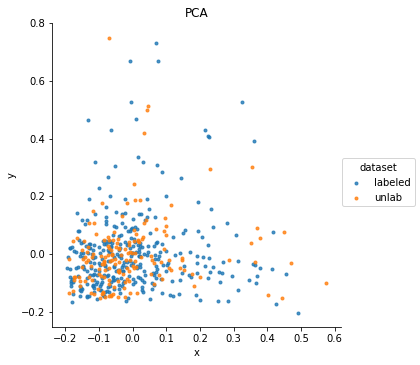

In [81]:
lm = sns.lmplot('x','y', X_pca.sample(500),hue='dataset',
           
           size=5, markers='.',fit_reg=False,
                x_jitter=.1, y_jitter=.1,
            )

axes = lm.axes

plt.title("PCA")
# axes[0,1].set_ylim(-20, 20)

In [27]:
# Method: train PCA in train set, project in others

# # X_train_tsne = TSNE(learning_rate=100).fit_transform(X_train)
# X_train_pca = pca.fit_transform(X_train)
# X_train_sample = resample(X_train, n_samples=n_samples2, random_state=0)
# X_train_pca = pca.transform(X_train_sample)

# # X_test_tsne = TSNE(learning_rate=100).transform(X_test)
# X_test_sample = resample(X_test, n_samples=n_samples2, random_state=0)
# X_test_pca = pca.transform(X_test_sample)

# # X_unlab_tsne = TSNE(learning_rate=100).transform(X_unlab)
# X_unlab_sample = resample(X_train, n_samples=n_samples2, random_state=0)
# X_unlab_pca = pca.transform(X_unlab_sample)

In [28]:
# from matplotlib.pyplot import scatter, figure,subplot

In [29]:
# figure(figsize=(20, 10))
# # subplot(121)
# scatter(X_train_pca, X_test_pca, X_unlab_pca, c=['green', 'blue', 'red'])
# # subplot(122)
# # scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target)


# t-SNE

In [82]:
X_tsne = TSNE(perplexity=40, verbose=2, n_iter=1100).fit_transform(X_all_us)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 31228 samples in 0.272s...
[t-SNE] Computed neighbors for 31228 samples in 389.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31228
[t-SNE] Computed conditional probabilities for sample 2000 / 31228
[t-SNE] Computed conditional probabilities for sample 3000 / 31228
[t-SNE] Computed conditional probabilities for sample 4000 / 31228
[t-SNE] Computed conditional probabilities for sample 5000 / 31228
[t-SNE] Computed conditional probabilities for sample 6000 / 31228
[t-SNE] Computed conditional probabilities for sample 7000 / 31228
[t-SNE] Computed conditional probabilities for sample 8000 / 31228
[t-SNE] Computed conditional probabilities for sample 9000 / 31228
[t-SNE] Computed conditional probabilities for sample 10000 / 31228
[t-SNE] Computed conditional probabilities for sample 11000 / 31228
[t-SNE] Computed conditional probabilities for sample 12000 / 31228
[t-SNE] Computed conditional probabilities for 

In [83]:
X_tsne = pd.DataFrame(X_tsne, columns=['x','y'])
X_tsne['dataset'] = y

In [84]:
# figure(figsize=(20, 10))
# plt.scatter(X_tsne[:n_samples2], X_tsne[n_samples2:2*n_samples2], X_tsne[2*n_samples2:],  c=['green', 'blue', 'red'])
# plt.title('tSNE on 250 samples from each dataset')

In [85]:
len(X_tsne)

31228

Text(0.5,1,'t-SNE in similar > 5e7')

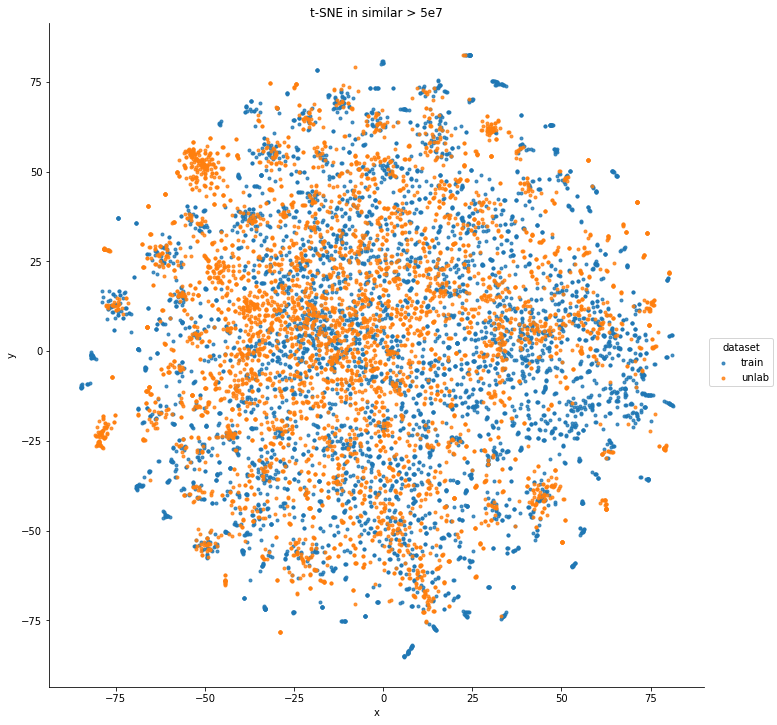

In [91]:
n_eg_per_dataset = 5000
X_tsne_sampled = X_tsne[X_tsne['dataset']=='train'].sample(n_eg_per_dataset)
# X_tsne_sampled = X_tsne_sampled.append(X_tsne[X_tsne['dataset']=='test'].sample(n_eg_per_dataset))
X_tsne_sampled = X_tsne_sampled.append(X_tsne[X_tsne['dataset']=='unlab'].sample(n_eg_per_dataset))

lm = sns.lmplot('x','y', X_tsne_sampled ,hue='dataset',
           size=10, markers='.',fit_reg=False,
                #x_jitter=.1, y_jitter=.1,
            )

axes = lm.axes

plt.title("t-SNE in similar > 5e7")
# axes[0,1].set_ylim(-20, 20)

Text(0.5,1,'t-SNE between train/test set')

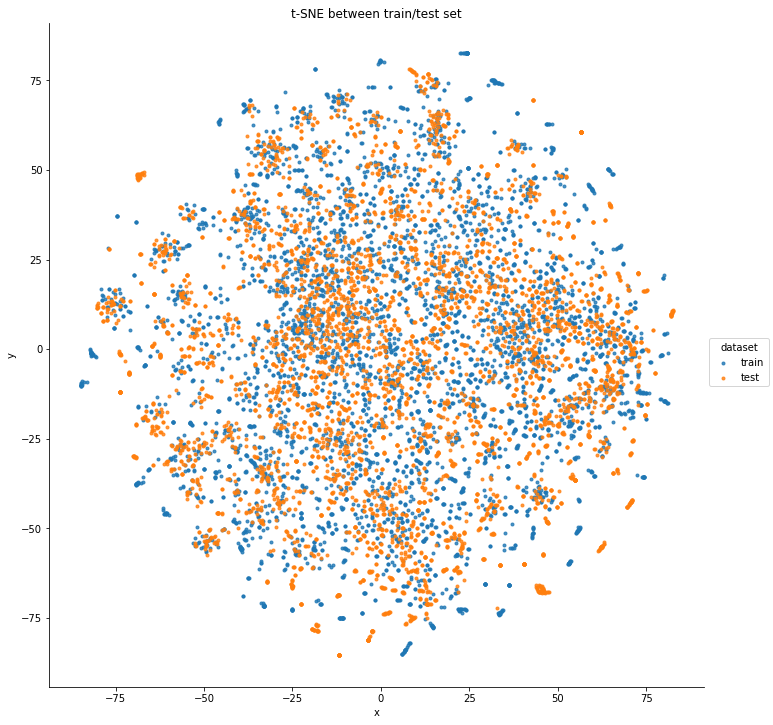

In [93]:
n_eg_per_dataset = 5000
X_tsne_sampled = X_tsne[X_tsne['dataset']=='train'].sample(n_eg_per_dataset)
X_tsne_sampled = X_tsne_sampled.append(X_tsne[X_tsne['dataset']=='test'].sample(n_eg_per_dataset))

lm = sns.lmplot('x','y', X_tsne_sampled ,hue='dataset',
           size=10, markers='.',fit_reg=False,
                #x_jitter=.1, y_jitter=.1,
            )

axes = lm.axes

plt.title("t-SNE between train/test set")
# axes[0,1].set_ylim(-20, 20)

In [ ]:
# TODO: keep only results with similarity > 5e7

Text(0.5,1,'t-SNE in docs with similarity > 5e7')

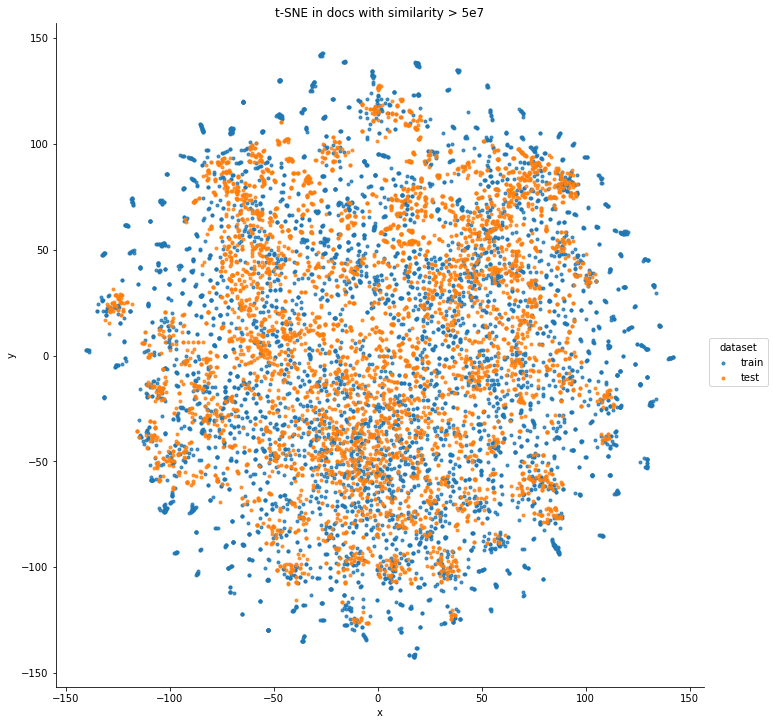

In [245]:
lm = sns.lmplot('x','y', X_tsne_sampled ,hue='dataset',
           size=10, markers='.',fit_reg=False,
                #x_jitter=.1, y_jitter=.1,
            )

axes = lm.axes

plt.title("t-SNE in all docs with similarity > 5e7")
# axes[0,1].set_ylim(-20, 20)

In [ ]:
# TODO: determine avg sentence length in each dataset

# TODO: count vectorizer for each sentence
# find distributions of each word in lbld, unlbld set

In [105]:
from scipy.stats import ks_2samp

In [215]:
n_samples = 8000
df_train_sampled = df_train.sample(n_samples)
df_test_sampled = df_test.sample(n_samples)
df_unlab_sampled = df_unlab_sim.sample(n_samples)

df_all_sampled = df_train_sampled.append(df_test_sampled.append(df_unlab_sampled))

In [134]:
cv = CountVectorizer()

In [135]:
cv.fit(df_all_sampled.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [136]:
train_distr = cv.transform(df_train_sampled.text)
test_distr = cv.transform(df_test_sampled.text)
unlab_distr = cv.transform(df_unlab_sampled.text)


In [137]:
train_distr = map(lambda m: m.item(), train_distr.mean(axis=1))
test_distr = map(lambda m: m.item(), test_distr.mean(axis=1))
unlab_distr = map(lambda m: m.item(), unlab_distr.mean(axis=1))

In [138]:
ks_2samp(train_distr, test_distr)

Ks_2sampResult(statistic=0.022374999999999978, pvalue=0.035885674638720833)

In [139]:
ks_2samp(train_distr, unlab_distr)

Ks_2sampResult(statistic=0.024875000000000036, pvalue=0.013897404870536147)

In [140]:
ks_2samp(test_distr, unlab_distr)

Ks_2sampResult(statistic=0.013124999999999942, pvalue=0.49353694211715293)